## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512 

50000/50000 [==============================] - 2s 32us/step - loss: 0.5493 - accuracy: 0.8389 - val_loss: 1.6397 - val_accuracy: 0.4932
Epoch 47/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5319 - accuracy: 0.8480 - val_loss: 1.6448 - val_accuracy: 0.4885
Epoch 48/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5157 - accuracy: 0.8541 - val_loss: 1.6937 - val_accuracy: 0.4825
Epoch 49/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5004 - accuracy: 0.8592 - val_loss: 1.6635 - val_accuracy: 0.4891
Epoch 50/50
10000/10000 [==============================] - 1s 71us/step


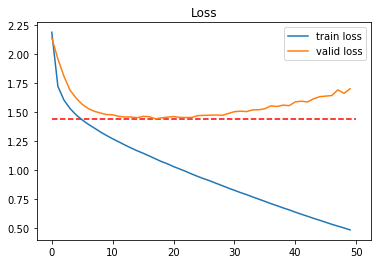

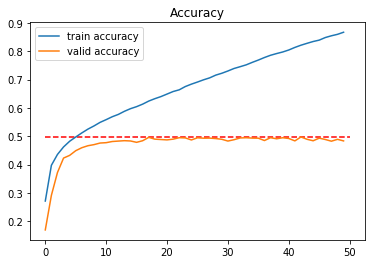

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512 

50000/50000 [==============================] - 2s 35us/step - loss: 0.5518 - accuracy: 0.8383 - val_loss: 1.6427 - val_accuracy: 0.4914
Epoch 47/50
50000/50000 [==============================] - 2s 34us/step - loss: 0.5347 - accuracy: 0.8448 - val_loss: 1.6313 - val_accuracy: 0.4987
Epoch 48/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.5179 - accuracy: 0.8518 - val_loss: 1.6780 - val_accuracy: 0.4855
Epoch 49/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5028 - accuracy: 0.8580 - val_loss: 1.6735 - val_accuracy: 0.4943
Epoch 50/50
10000/10000 [==============================] - 1s 84us/step


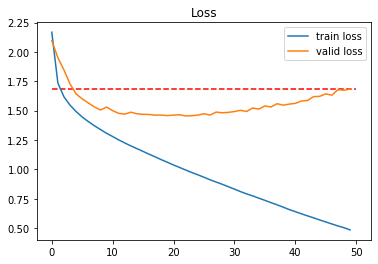

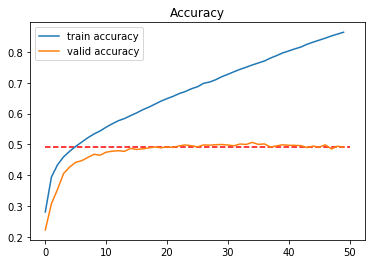

In [13]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

results = {}
for save_best_only in [True, False]:
    model_ckpt = ModelCheckpoint(filepath="./tmp_"+str(save_best_only)+".h5", 
                             monitor="val_loss", 
                             save_best_only=save_best_only)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )
    # Collect results    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    name_tag = 'save_best_only: %s' % str(save_best_only)
    results[name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}
    
    # Load back
    model = keras.models.load_model("./tmp_"+str(save_best_only)+".h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

# 請僅存入將 save_weights_only 設定為 True

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512

50000/50000 [==============================] - 2s 41us/step - loss: 0.5543 - accuracy: 0.8386 - val_loss: 1.6284 - val_accuracy: 0.4986
Epoch 47/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.5359 - accuracy: 0.8464 - val_loss: 1.6453 - val_accuracy: 0.4915
Epoch 48/50
50000/50000 [==============================] - 2s 34us/step - loss: 0.5182 - accuracy: 0.8525 - val_loss: 1.6679 - val_accuracy: 0.4906
Epoch 49/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5033 - accuracy: 0.8581 - val_loss: 1.6692 - val_accuracy: 0.4929
Epoch 50/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.4853 - accuracy: 0.8653 - val_loss: 1.6913 - val_accuracy: 0.4938


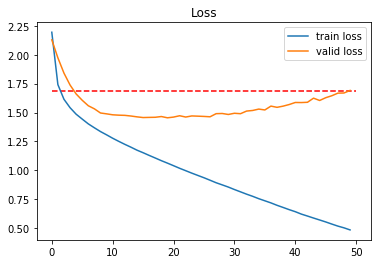

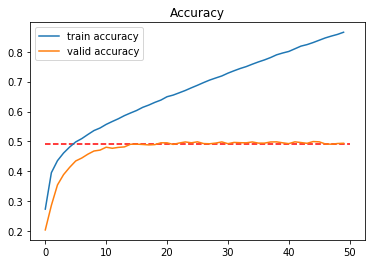

In [18]:
from keras.callbacks import ModelCheckpoint

results = {}

model_ckpt = ModelCheckpoint(filepath="./tmp_save_weights_only.h5", 
                         monitor="val_loss", 
                         save_weights_only=True)
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

# 嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [19]:
model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("./tmp_true.h5")

## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
# You must compile a model before training/testing
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
# testing
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

print("loss_loadback", loss_loadback, "\n")
print("acc_loadback", acc_loadback, "\n")

10000/10000 [==============================] - 1s 90us/step
loss_loadback 1.4432090333938599 

acc_loadback 0.4959999918937683 

